In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
cd ../dataset/

/Users/luyao/Desktop/求职/DS-Take-Home/dataset


In [3]:
data = pd.read_csv('employee_retention_data.csv', parse_dates=['join_date', 'quit_date'])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      13510 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [5]:
data.describe(include = 'all')

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
count,24702.000000,24702.000000,24702,24702.000000,24702.000000,24702,13510
unique,NaN,NaN,6,NaN,NaN,995,664
top,NaN,NaN,customer_service,NaN,NaN,2012-01-03 00:00:00,2015-05-08 00:00:00
freq,NaN,NaN,9180,NaN,NaN,105,111
first,NaN,NaN,NaN,NaN,NaN,2011-01-24 00:00:00,2011-10-13 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2015-12-10 00:00:00,2015-12-09 00:00:00
mean,501604.403530,3.426969,NaN,14.127803,138183.345478,NaN,NaN
std,288909.026101,2.700011,NaN,8.089520,76058.184573,NaN,NaN
min,36.000000,1.000000,NaN,1.000000,17000.000000,NaN,NaN
25%,250133.750000,1.000000,NaN,7.000000,79000.000000,NaN,NaN


In [6]:
# Null information
data.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

## Create a table with 3 columns: day, employee_headcount, company_id.

In [9]:
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(data['company_id'].unique())

In [10]:
day = []
company = []
headcount = []

for date in unique_date:
    for idx in unique_company:
        total_join = len(data[(data['join_date'] <= date) & (data['company_id'] == idx)])
        total_quit = len(data[(data['quit_date'] <= date) & (data['company_id'] == idx)])
        day.append(date)
        company.append(idx)
        headcount.append(total_join - total_quit)
        
# Create table for day, employee_headcount, company_id
table = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount}, 
                     columns=['day', 'company_id', 'employee_headcount'])

In [11]:
table.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


## Employee Churn Analysis

### Feature Engineering

how many days was the employee be employed? This should matter.
People might get bored in the same place for too long.

In [12]:
# Separate stay and quit data
quit_data = data[~data['quit_date'].isnull()]
stay_data = data[data['quit_date'].isnull()]

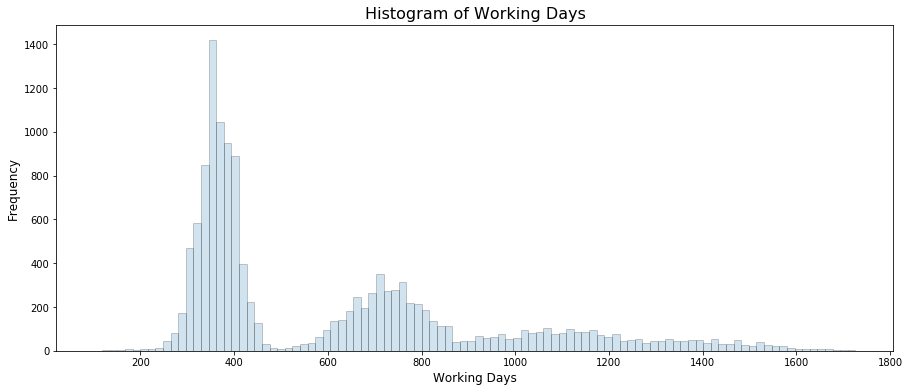

In [11]:
workdays = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date'])))

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(workdays, bins=100, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

This graph shows that people are easy to get boring and quit around 1 year.

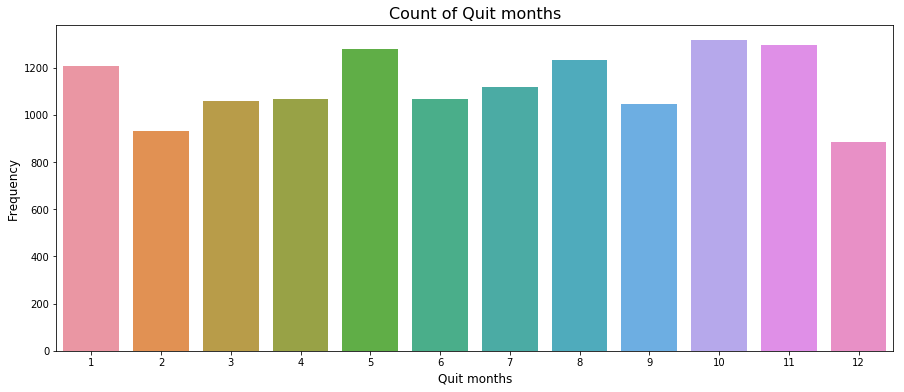

In [12]:
month = np.array(list(map(lambda x: x.month, quit_data['quit_date'] )))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(month, ax=ax)
ax.set_title('Count of Quit months', fontsize=16)
ax.set_xlabel('Quit months', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

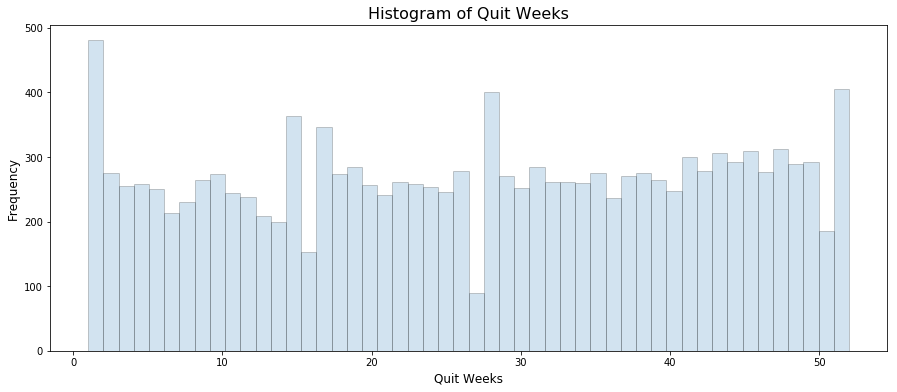

In [13]:
weeks  = np.array(list(map(lambda x: x.week, quit_data['quit_date'])))

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(weeks , bins=50, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Quit Weeks', fontsize=16)
ax.set_xlabel('Quit Weeks', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

And it also peaks around the new year. Makes sense, companies have much more money to hire at the beginning of the year.

Now, let’s see if we find the characteristics of the people who quit early. Looking at the histogram of employment_length, it looks like we could define early quitters as those people who quit within 1 yr or so. So, let’s create two classes of users : quit within 13 months or not (if they haven’t been in the current company for at least 13 months, we remove them).

In [14]:
# Choose quit data
quit_data['workdays'] = workdays
quit_data['weeks'] = weeks

quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,workdays,weeks
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,44
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,14
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,23
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,34
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,35


## Model

In [15]:
early_quit_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31)
subset = data[data['join_date'] < early_quit_date]

In [16]:
# Binary label for early quit (less than 13 months)
quit = subset['quit_date'].notnull() & (subset['quit_date'] < subset['join_date'] + pd.DateOffset(days=396))
subset['quit'] = quit.astype(int)

subset.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


Then we build the model:
Here we can just care about: seniority, salary, dept and company. A simple decision tree is probably more than enough.

In [28]:
#LabelEncoder

le = LabelEncoder()
train_x = subset[['company_id', 'seniority', 'salary']]
train_x['dept'] = le.fit_transform(subset['dept'])
train_y = subset['quit'].values

train_x.head()

,company_id,seniority,salary,dept
0,7,28,89000.0,0
1,7,20,183000.0,4
2,4,14,101000.0,4
3,7,20,115000.0,0
4,2,23,276000.0,1


In [29]:
# Build decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=train_x, y=train_y)

In [30]:
# Feature importance
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 1.00000
company_id | 0.00000
seniority  | 0.00000
dept       | 0.00000


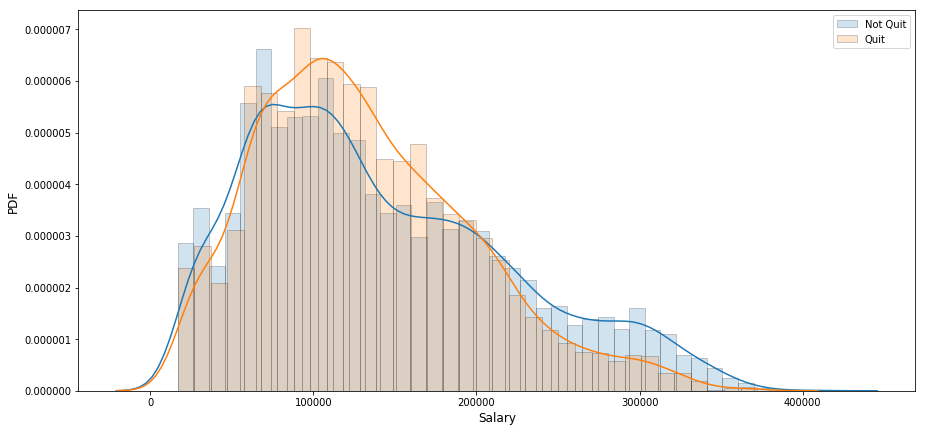

In [27]:
# Visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(subset[subset['quit']==0]['salary'], 
             label='Not Quit', ax=ax, hist_kws=hist_kws)
sns.distplot(subset[subset['quit']==1]['salary'], 
             label='Quit', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('Salary', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()